# Введение

## Название проекта

"Кто нас посетит в течении 90 дней?"

## Цель работы

Предсказать вероятность покупки в течение 90 дней

## Цель работы план работы

● Изучить данные

● Разработать полезные признаки

● Создать модель для классификации пользователей

● Улучшить модель и максимизировать метрику roc_auc

● Выполнить тестирование

## Описание данных

apparel-purchases история покупок

● client_id идентификатор пользователя

● quantity количество товаров в заказе

● price цена товара

● category_ids вложенные категории, к которым отнсится товар

● date дата покупки

● message_id идентификатор сообщения из рассылки

apparel-messages история рекламных рассылок

● bulk_campaign_id идентификатор рекламной кампании

● client_id идентификатор пользователя

● message_id идентификатор сообщений

● event тип действия

● channel канал рассылки

● date дата рассылки

● created_at точное время создания сообщения

apparel-target_binary совершит ли клиент покупку в течение следующих 90 дней

● client_id идентификатор пользователя

● target целевой признак


# Обзор данных из файла

## Загрузка библиотек

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.metrics import jaccard_score
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
RANDOM_STATE = 42
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier


## Загрузка файлов

In [14]:
purchases = pd.read_csv(r"C:\Users\levle\OneDrive\Documents\Yandex_Practicum_main\Master2\filtered_data\apparel-purchases.csv", sep=',')

In [15]:
messages = pd.read_csv(r"C:\Users\levle\OneDrive\Documents\Yandex_Practicum_main\Master2\filtered_data\apparel-messages.csv", sep=',')

In [16]:
target = pd.read_csv(r"C:\Users\levle\OneDrive\Documents\Yandex_Practicum_main\Master2\filtered_data\apparel-target_binary.csv", sep=',')

In [17]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [18]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [19]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


### Вывод

Дата загруженны корректно

# Предобработка и исследовательский анализ данных

## Проверка форматов

### Purchases

In [25]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [26]:
purchases.describe()

,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459514e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


date надо поменять в формат даты

In [28]:
purchases['date'] = pd.to_datetime(purchases['date'], format='%Y-%m-%d')

### Messages

In [30]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [31]:
messages.describe()

,bulk_campaign_id,client_id
count,1.273980e+07,1.273980e+07
mean,1.160459e+04,1.515916e+18
std,3.259211e+03,3.265518e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18


Даты надо поменять в правельный формат

In [33]:
messages['date'] = pd.to_datetime(messages['date'], format='%Y-%m-%d')

In [34]:
messages['created_at'] = pd.to_datetime(messages['created_at'])

### Target

In [36]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [37]:
target.describe()

,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


## Проверка явных дубликатов

In [39]:
def find_duplicates(dataframe):
    duplicates = dataframe.duplicated()
    duplicated_rows = dataframe[duplicates]
    duplicate_count = len(duplicated_rows)  
    return duplicated_rows, duplicate_count

### Purchases

In [41]:
duplicated_rows, duplicate_count = find_duplicates(purchases)

In [42]:
duplicated_rows

,client_id,quantity,price,category_ids,date,message_id
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
42,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
59,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
62,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078
...,...,...,...,...,...,...
202200,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202201,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202202,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8


In [43]:
duplicate_count

73020

Из 202тыс строк, 73тыс это дубликаты? Может эти дубликаты созданы только малым количеством клиентов?

In [45]:
purchases['client_id'].nunique()

49849

In [46]:
duplicated_rows['client_id'].nunique()

27210

In [47]:
#Я не думаю что есть вероятный сценарий при котором тот же самый клиент будет в тот же день оформлять несколько заказов на один и тот же продукт по той же самой цене. Возможно если у нас продажи по акции где "1 такой продукт на одну карзину по такой цене", но у нас нету этой информации поэтому дубликаты я удаляю. в идеале эту информацию нужно подтвердить с тем кто предоставил данные

In [48]:
# Так же замечу что есть продажи где количество товара выше 1, это значит что нет нужды создавать несколько строк данных ради заказа более одного количества товара.

#### Пометка

Перечитав ТЗ и посмотрев на данные я считаю что:

- это не дубликаты
- у нас нет данных о product_id и order_id
- у нас есть только "категория" продукта, а в одной и той же категории по той же самой цене может быть несколько продуктов. Допустим освежители разного запаха

In [50]:
#purchases_no_dupe = purchases.drop_duplicates()

In [51]:
#purchases_no_dupe.info()

### Messages

In [53]:
duplicated_rows, duplicate_count = find_duplicates(messages)

In [54]:
duplicate_count

48610

In [55]:
messages_no_dupe = messages.drop_duplicates()

In [56]:
messages_no_dupe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 774.6+ MB


In [57]:
messages_no_dupe.isnull().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

### Target

In [59]:
duplicated_rows, duplicate_count = find_duplicates(target)

In [60]:
duplicate_count

0

# Соединение таргет и продаж

In [62]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [63]:
merged_df = purchases.merge(target, on='client_id', how='inner')

In [64]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
 6   target        202208 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 10.8+ MB


# Создание новых признаков

## Чистка категории

In [67]:
merged_df.head()

,client_id,quantity,price,category_ids,date,message_id,target
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0
2,1515915625468169594,1,742.0,"['2', '18', '258', '1569']",2022-10-19,1515915625468169594-7180-634d2f82d8799,0
3,1515915625468169594,1,1050.0,"['4', '28', '124', '1602']",2023-06-30,1515915625468169594-13392-649554cd9b5ee,0
4,1515915625468169594,1,864.0,"['4', '28', '124', '1602']",2023-06-30,1515915625468169594-13392-649554cd9b5ee,0


In [68]:
merged_df['category_ids'] = merged_df['category_ids'].apply(ast.literal_eval)
merged_df['category_length'] = merged_df['category_ids'].apply(len)

In [69]:
merged_df['category_length'].unique()

array([4, 5, 1, 0, 3], dtype=int64)

<Axes: >

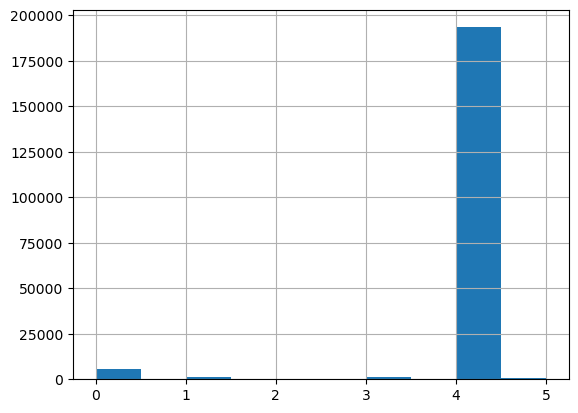

In [70]:
merged_df['category_length'].hist()

### Пометка
Пробовал разные методы как можно провести кластеризацию и тд, но ничего толком не сработало. Поэтому буду сортировать и разбивать списки на кат1 кат2 и тд

Максимальное количество категрий = 5 а минимальное = 0

In [73]:
merged_df['category_ids'] = merged_df['category_ids'].apply(
    lambda x: sorted([int(i) for i in x if i is not None]) if isinstance(x, list) else x
)


In [74]:
category_cols = merged_df['category_ids'].apply(
    lambda x: x + [None] * (5 - len(x)) if isinstance(x, list) else [None] * 5
)

category_cols_df = pd.DataFrame(category_cols.tolist(), columns=['Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5'])

for col in ['Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5']:
    category_cols_df[col] = category_cols_df[col].fillna(0).astype(int)
    category_cols_df[col] = category_cols_df[col].astype(object)

merged_df = pd.concat([merged_df, category_cols_df], axis=1)

In [75]:
merged_df.head()

,client_id,quantity,price,category_ids,date,message_id,target,category_length,Cat1,Cat2,Cat3,Cat4,Cat5
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,0,4,4,28,57,431,0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,0,4,4,28,57,431,0
2,1515915625468169594,1,742.0,"[2, 18, 258, 1569]",2022-10-19,1515915625468169594-7180-634d2f82d8799,0,4,2,18,258,1569,0
3,1515915625468169594,1,1050.0,"[4, 28, 124, 1602]",2023-06-30,1515915625468169594-13392-649554cd9b5ee,0,4,4,28,124,1602,0
4,1515915625468169594,1,864.0,"[4, 28, 124, 1602]",2023-06-30,1515915625468169594-13392-649554cd9b5ee,0,4,4,28,124,1602,0


In [76]:
merged_df = merged_df.drop(columns=['category_ids'])

## order_data сгруппируем покупки по дням и клиентам

Представим что каждые клиент может соверщить лишь один заказ в день

In [79]:
merged_df.head()

,client_id,quantity,price,date,message_id,target,category_length,Cat1,Cat2,Cat3,Cat4,Cat5
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,0,4,4,28,57,431,0
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,0,4,4,28,57,431,0
2,1515915625468169594,1,742.0,2022-10-19,1515915625468169594-7180-634d2f82d8799,0,4,2,18,258,1569,0
3,1515915625468169594,1,1050.0,2023-06-30,1515915625468169594-13392-649554cd9b5ee,0,4,4,28,124,1602,0
4,1515915625468169594,1,864.0,2023-06-30,1515915625468169594-13392-649554cd9b5ee,0,4,4,28,124,1602,0


In [80]:
order_data = merged_df.groupby(['client_id', 'date', 'target']).agg({
    'quantity': 'sum',
    'price': 'sum'
}).reset_index()

In [81]:
order_data.head()

,client_id,date,target,quantity,price
0,1515915625468060902,2022-05-27,0,7,6993.0
1,1515915625468061003,2023-01-04,1,7,16235.0
2,1515915625468061099,2022-05-17,0,1,299.0
3,1515915625468061100,2024-02-10,0,2,2098.0
4,1515915625468061170,2023-03-26,0,4,5412.0


Теперь стоит создать несколько метрик как средний заказ, расстояние в днях между заказами и тд

In [83]:
order_data['date'] = pd.to_datetime(order_data['date'])

# Sort by client_id and date
order_data = order_data.sort_values(by=['client_id', 'date'])

# Calculate the number of days to the next order
order_data['next_order_date'] = order_data.groupby('client_id')['date'].shift(-1)
order_data['days_until_next_order'] = (order_data['next_order_date'] - order_data['date']).dt.days

In [84]:
order_data.head()

,client_id,date,target,quantity,price,next_order_date,days_until_next_order
0,1515915625468060902,2022-05-27,0,7,6993.0,NaT,NaN
1,1515915625468061003,2023-01-04,1,7,16235.0,NaT,NaN
2,1515915625468061099,2022-05-17,0,1,299.0,NaT,NaN
3,1515915625468061100,2024-02-10,0,2,2098.0,NaT,NaN
4,1515915625468061170,2023-03-26,0,4,5412.0,2023-03-29,3.0


## average_client_order profile

In [86]:
average_client_metrics = order_data.groupby(['client_id', 'target']).agg({
    'quantity': 'sum',
    'price': 'sum',
    'date' : 'count',
    'days_until_next_order' : 'sum'
}).rename(columns={'date': 'order_count', 'days_until_next_order':'avg_days_until_next_order'}).reset_index()

In [87]:
average_client_metrics['avg_days_until_next_order'] = average_client_metrics['avg_days_until_next_order']/(average_client_metrics['order_count']-1)

In [88]:
average_client_metrics.head()

,client_id,target,quantity,price,order_count,avg_days_until_next_order
0,1515915625468060902,0,7,6993.0,1,NaN
1,1515915625468061003,1,7,16235.0,1,NaN
2,1515915625468061099,0,1,299.0,1,NaN
3,1515915625468061100,0,2,2098.0,1,NaN
4,1515915625468061170,0,19,33601.0,3,41.5


In [89]:
average_client_metrics['customer_type'] = average_client_metrics['order_count'].apply(
    lambda x: 'multiple' if x > 1 else 'single'
)

In [90]:
average_client_metrics.head()

,client_id,target,quantity,price,order_count,avg_days_until_next_order,customer_type
0,1515915625468060902,0,7,6993.0,1,NaN,single
1,1515915625468061003,1,7,16235.0,1,NaN,single
2,1515915625468061099,0,1,299.0,1,NaN,single
3,1515915625468061100,0,2,2098.0,1,NaN,single
4,1515915625468061170,0,19,33601.0,3,41.5,multiple


In [91]:
average_client_metrics['avg_order_spent'] = average_client_metrics['price']/average_client_metrics['order_count']

In [92]:
average_client_metrics['avg_items_per_order'] = average_client_metrics['quantity']/average_client_metrics['order_count']

In [93]:
average_client_metrics['avg_items_price'] = average_client_metrics['price']/average_client_metrics['quantity']

In [94]:
average_client_metrics.head()

,client_id,target,quantity,price,order_count,avg_days_until_next_order,customer_type,avg_order_spent,avg_items_per_order,avg_items_price
0,1515915625468060902,0,7,6993.0,1,NaN,single,6993.000000,7.000000,999.000000
1,1515915625468061003,1,7,16235.0,1,NaN,single,16235.000000,7.000000,2319.285714
2,1515915625468061099,0,1,299.0,1,NaN,single,299.000000,1.000000,299.000000
3,1515915625468061100,0,2,2098.0,1,NaN,single,2098.000000,2.000000,1049.000000
4,1515915625468061170,0,19,33601.0,3,41.5,multiple,11200.333333,6.333333,1768.473684


In [95]:
last_client_order_date = order_data.groupby(['client_id']).agg({
    'date' : 'max',
}).rename(columns={'date': 'last_order_date'}).reset_index()

In [96]:
average_client_metrics = average_client_metrics.merge(last_client_order_date, on=['client_id'])

In [97]:
max_date = merged_df['date'].max()

In [98]:
max_date

Timestamp('2024-02-16 00:00:00')

In [99]:
average_client_metrics['extraction_date'] = max_date + pd.Timedelta(days=1)

In [100]:
average_client_metrics['days_between_extraction_last_order'] = (average_client_metrics['extraction_date'] - average_client_metrics['last_order_date']).dt.days

### Пометка

Создал много новых полей для профиля покупателя. теперь стоит обратить внимание на статус сообщений который мы отправляли клиенту

In [102]:
average_client_metrics.head()

,client_id,target,quantity,price,order_count,avg_days_until_next_order,customer_type,avg_order_spent,avg_items_per_order,avg_items_price,last_order_date,extraction_date,days_between_extraction_last_order
0,1515915625468060902,0,7,6993.0,1,NaN,single,6993.000000,7.000000,999.000000,2022-05-27,2024-02-17,631
1,1515915625468061003,1,7,16235.0,1,NaN,single,16235.000000,7.000000,2319.285714,2023-01-04,2024-02-17,409
2,1515915625468061099,0,1,299.0,1,NaN,single,299.000000,1.000000,299.000000,2022-05-17,2024-02-17,641
3,1515915625468061100,0,2,2098.0,1,NaN,single,2098.000000,2.000000,1049.000000,2024-02-10,2024-02-17,7
4,1515915625468061170,0,19,33601.0,3,41.5,multiple,11200.333333,6.333333,1768.473684,2023-06-17,2024-02-17,245


In [103]:
#conditions = [
#    (average_client_metrics['days_between_extraction_last_order'] < 30),
#    (average_client_metrics['days_between_extraction_last_order'] < 60),
#    (average_client_metrics['days_between_extraction_last_order'] < 90),
#    (average_client_metrics['days_between_extraction_last_order'] < 120)
#]

#categories = [
#    'ordered in 30 days',
#    'ordered in 60 days',
#    'ordered in 90 days',
#    'ordered in 120 days'
#]

# Apply conditions to assign categories
#average_client_metrics['days_from_last_order_cat'] = np.select(
#    conditions, 
#    categories, 
#    default='150 days plus'
#)

идею проверил но она переобучает модель

In [105]:
average_client_metrics.head()

,client_id,target,quantity,price,order_count,avg_days_until_next_order,customer_type,avg_order_spent,avg_items_per_order,avg_items_price,last_order_date,extraction_date,days_between_extraction_last_order
0,1515915625468060902,0,7,6993.0,1,NaN,single,6993.000000,7.000000,999.000000,2022-05-27,2024-02-17,631
1,1515915625468061003,1,7,16235.0,1,NaN,single,16235.000000,7.000000,2319.285714,2023-01-04,2024-02-17,409
2,1515915625468061099,0,1,299.0,1,NaN,single,299.000000,1.000000,299.000000,2022-05-17,2024-02-17,641
3,1515915625468061100,0,2,2098.0,1,NaN,single,2098.000000,2.000000,1049.000000,2024-02-10,2024-02-17,7
4,1515915625468061170,0,19,33601.0,3,41.5,multiple,11200.333333,6.333333,1768.473684,2023-06-17,2024-02-17,245


### Messages

In [107]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [108]:
messages[messages['message_id'] == '1515915625468169594-13392-649554cd9b5ee']

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
5851006,13392,1515915625468169594,1515915625468169594-13392-649554cd9b5ee,send,email,2023-06-23,2023-06-23 08:17:34
5871646,13392,1515915625468169594,1515915625468169594-13392-649554cd9b5ee,open,email,2023-06-23,2023-06-23 10:41:24
6004827,13392,1515915625468169594,1515915625468169594-13392-649554cd9b5ee,open,email,2023-06-30,2023-06-30 16:58:41
6004829,13392,1515915625468169594,1515915625468169594-13392-649554cd9b5ee,click,email,2023-06-30,2023-06-30 16:59:01
6004877,13392,1515915625468169594,1515915625468169594-13392-649554cd9b5ee,purchase,email,2023-06-30,2023-06-30 17:10:25


In [109]:
messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [110]:
last_events = messages.sort_values(by=['created_at']).groupby('client_id').last().reset_index()

In [111]:
last_events = last_events[['event', 'client_id']]

In [112]:
last_events.head()

,event,client_id
0,unsubscribe,1515915625468060902
1,send,1515915625468061003
2,send,1515915625468061099
3,open,1515915625468061100
4,send,1515915625468061170


In [113]:
#additional_metrics = messages.groupby(['message_id', 'client_id']).agg(
#    min_created_at=('created_at', 'min'),
#    max_created_at=('created_at', 'max'),
#    record_count=('created_at', 'count')
#).reset_index()

In [114]:
#additional_metrics['time_diff_seconds'] = (
#    additional_metrics['max_created_at'] - additional_metrics['min_created_at']
#).dt.total_seconds()

In [115]:
#additional_metrics.rename(columns={'record_count': 'message_event_count'}, inplace=True)

In [116]:
#grouped_metrics = additional_metrics.groupby('client_id').agg(
#    avg_message_interactions=('message_event_count', 'mean'),
#    avg_time_in_message=('time_diff_seconds', 'mean')
#).reset_index()

In [117]:
#grouped_metrics.head()

Это была интересная идея но при проверке она переобучивала модель

In [119]:
average_client_metrics = average_client_metrics.merge(last_events, on=['client_id'])

In [120]:
#average_client_metrics = average_client_metrics.merge(grouped_metrics, on=['client_id'])

In [121]:
average_client_metrics.head()

,client_id,target,quantity,price,order_count,avg_days_until_next_order,customer_type,avg_order_spent,avg_items_per_order,avg_items_price,last_order_date,extraction_date,days_between_extraction_last_order,event
0,1515915625468060902,0,7,6993.0,1,NaN,single,6993.000000,7.000000,999.000000,2022-05-27,2024-02-17,631,unsubscribe
1,1515915625468061003,1,7,16235.0,1,NaN,single,16235.000000,7.000000,2319.285714,2023-01-04,2024-02-17,409,send
2,1515915625468061099,0,1,299.0,1,NaN,single,299.000000,1.000000,299.000000,2022-05-17,2024-02-17,641,send
3,1515915625468061100,0,2,2098.0,1,NaN,single,2098.000000,2.000000,1049.000000,2024-02-10,2024-02-17,7,open
4,1515915625468061170,0,19,33601.0,3,41.5,multiple,11200.333333,6.333333,1768.473684,2023-06-17,2024-02-17,245,send


Стоит проверить есть ли данные где клиент отписался а таргет == 1

In [123]:
average_client_metrics[(average_client_metrics['event'] == 'unsubscribe') & (average_client_metrics['target'] == 1)]

,client_id,target,quantity,price,order_count,avg_days_until_next_order,customer_type,avg_order_spent,avg_items_per_order,avg_items_price,last_order_date,extraction_date,days_between_extraction_last_order,event


таких клиентов нет, что логично. Из-за этого стоит проверить и другие статусы но их удалять уже врядли буду

In [125]:
filtered_data = average_client_metrics[average_client_metrics['target'] == 1]

In [126]:
filtered_data['event'].value_counts()

event
send           513
open           262
click           58
hard_bounce      6
purchase         5
soft_bounce      2
Name: count, dtype: int64

In [127]:
average_client_metrics['event'].value_counts()


event
send           29571
open            9211
click           1107
purchase         737
hard_bounce      673
unsubscribe      473
soft_bounce      130
complain          80
Name: count, dtype: int64

In [128]:
average_client_metrics['event'].nunique()

8

### Пометка 
Видно что те кто подал жалобу тоже не совершат больше покупок с нами в Таргет дате

## Категории часть 2

ЗДесь я буду пробовать найти самую частую категорию покупок для клиента

In [131]:
merged_df['concatenated_cats'] = merged_df[['Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5']].astype(str).agg(' '.join, axis=1)

In [132]:
grouped_cats = merged_df.groupby('client_id')['concatenated_cats'].apply(lambda x: ' '.join(x))

In [133]:
def most_frequent_category(cat_string):
    categories = cat_string.split()
    cat_counts = pd.Series(categories).value_counts()
    most_frequent_cat = cat_counts.idxmax()
    most_frequent_count = cat_counts.max()
    return most_frequent_cat, most_frequent_count

In [134]:
grouped_cats_result = grouped_cats.apply(lambda x: most_frequent_category(x))

In [135]:
most_frequent_cats_per_client = pd.DataFrame(
    grouped_cats_result.tolist(), 
    index=grouped_cats.index, 
    columns=['Most_Frequent_Category', 'Count']
)

In [136]:
average_client_metrics = average_client_metrics.merge(most_frequent_cats_per_client, on=['client_id'])

In [137]:
#merged_df[merged_df['client_id'] == 1515915625468062556].head(20)

## Вывод

- Были обработаны 3 дата сета
- Был создан профиль клиента с разным набором метрик

# Проверка данных на мультиколлениарность

In [140]:
average_client_metrics.head()

,client_id,target,quantity,price,order_count,avg_days_until_next_order,customer_type,avg_order_spent,avg_items_per_order,avg_items_price,last_order_date,extraction_date,days_between_extraction_last_order,event,Most_Frequent_Category,Count
0,1515915625468060902,0,7,6993.0,1,NaN,single,6993.000000,7.000000,999.000000,2022-05-27,2024-02-17,631,unsubscribe,4,7
1,1515915625468061003,1,7,16235.0,1,NaN,single,16235.000000,7.000000,2319.285714,2023-01-04,2024-02-17,409,send,4,7
2,1515915625468061099,0,1,299.0,1,NaN,single,299.000000,1.000000,299.000000,2022-05-17,2024-02-17,641,send,4,1
3,1515915625468061100,0,2,2098.0,1,NaN,single,2098.000000,2.000000,1049.000000,2024-02-10,2024-02-17,7,open,4,2
4,1515915625468061170,0,19,33601.0,3,41.5,multiple,11200.333333,6.333333,1768.473684,2023-06-17,2024-02-17,245,send,0,27


In [141]:
average_client_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41982 entries, 0 to 41981
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   client_id                           41982 non-null  int64         
 1   target                              41982 non-null  int64         
 2   quantity                            41982 non-null  int64         
 3   price                               41982 non-null  float64       
 4   order_count                         41982 non-null  int64         
 5   avg_days_until_next_order           6360 non-null   float64       
 6   customer_type                       41982 non-null  object        
 7   avg_order_spent                     41982 non-null  float64       
 8   avg_items_per_order                 41982 non-null  float64       
 9   avg_items_price                     41982 non-null  float64       
 10  last_order_date       

In [142]:
model_data = average_client_metrics.drop(columns=['quantity', 'price', 'last_order_date', 'extraction_date', 'client_id', 'Count'])

In [143]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41982 entries, 0 to 41981
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   target                              41982 non-null  int64  
 1   order_count                         41982 non-null  int64  
 2   avg_days_until_next_order           6360 non-null   float64
 3   customer_type                       41982 non-null  object 
 4   avg_order_spent                     41982 non-null  float64
 5   avg_items_per_order                 41982 non-null  float64
 6   avg_items_price                     41982 non-null  float64
 7   days_between_extraction_last_order  41982 non-null  int64  
 8   event                               41982 non-null  object 
 9   Most_Frequent_Category              41982 non-null  object 
dtypes: float64(4), int64(3), object(3)
memory usage: 3.2+ MB


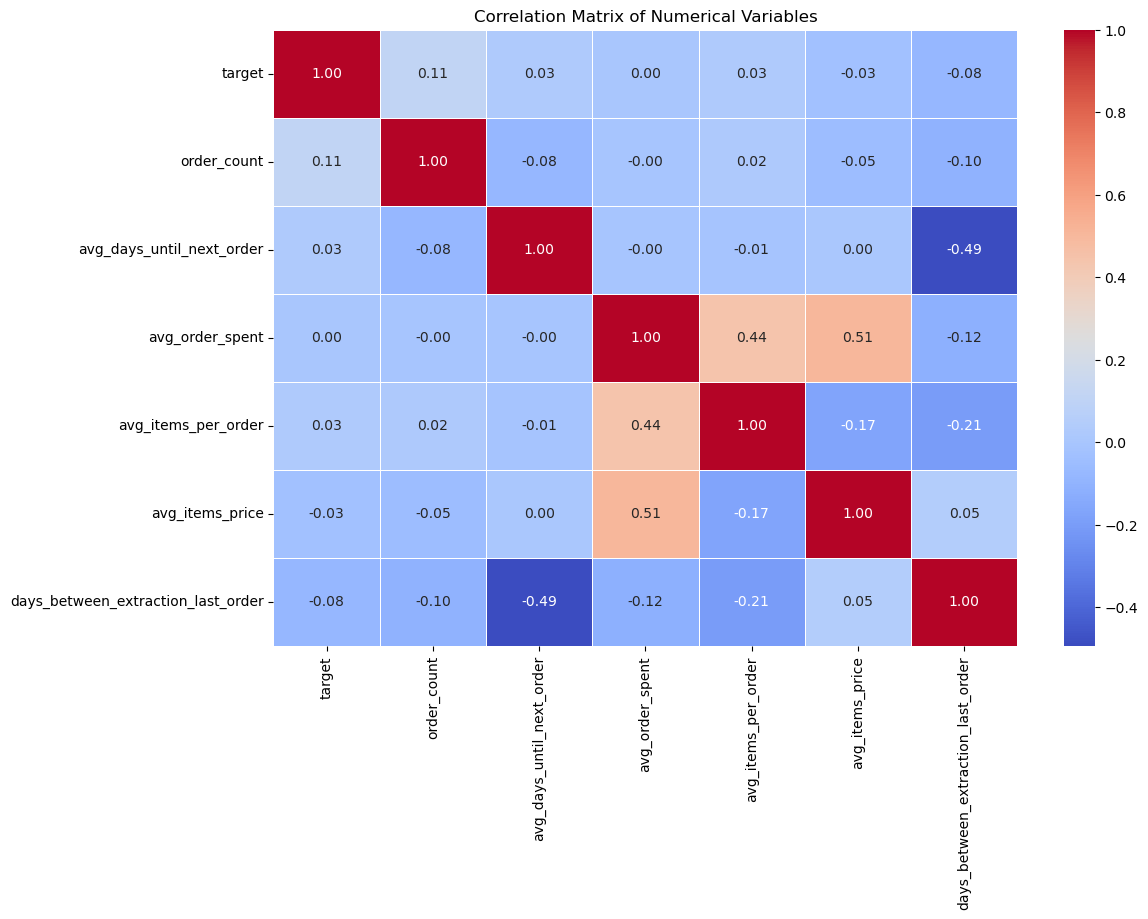

In [144]:
numeric_columns = model_data.select_dtypes(include=['float64', 'int64', 'int32'])
corr_matrix = numeric_columns.corr(method='pearson')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

Сильных мультикорреильностей нету

# Создание моделей

## Пайплайн

In [148]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41982 entries, 0 to 41981
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   target                              41982 non-null  int64  
 1   order_count                         41982 non-null  int64  
 2   avg_days_until_next_order           6360 non-null   float64
 3   customer_type                       41982 non-null  object 
 4   avg_order_spent                     41982 non-null  float64
 5   avg_items_per_order                 41982 non-null  float64
 6   avg_items_price                     41982 non-null  float64
 7   days_between_extraction_last_order  41982 non-null  int64  
 8   event                               41982 non-null  object 
 9   Most_Frequent_Category              41982 non-null  object 
dtypes: float64(4), int64(3), object(3)
memory usage: 3.2+ MB


In [149]:
ohe_columns = [ 'customer_type', 'event', 'Most_Frequent_Category'] #, 'days_from_last_order_cat'] 
ord_columns = []
num_columns = ['order_count', 'avg_days_until_next_order', 'avg_order_spent', 'avg_items_per_order', 'avg_items_price', 'days_between_extraction_last_order'] #, 'avg_message_interactions', 'avg_time_in_message']

In [150]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())
])

poly_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        # Skip ord_pipe if ord_columns is empty
        ('num', num_pipe, num_columns),
        ('poly', poly_pipe, num_columns)
    ]
)

In [151]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('num', num_pipe, num_columns),
    ('poly', poly_pipe, num_columns)
], remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

## Создание выборок

In [153]:
X = model_data.drop(['target'], axis=1)
y = model_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [154]:
print("Training feature set shape:", X_train.shape)
print("Testing feature set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training feature set shape: (33585, 9)
Testing feature set shape: (8397, 9)
Training labels shape: (33585,)
Testing labels shape: (8397,)


## Сетка параметров для RandomizedSearchCV

In [156]:
param_grid = [
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__max_depth': range(2, 10),
        'model__max_features': range(2, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__penalty': ['l2'],
        'model__C': [0.01, 0.1, 1, 10],  # Regularization parameter
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance'],  # Uniform or weighted distance
        'model__p': [1, 2],  # Manhattan (p=1) or Euclidean (p=2) distance
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LGBMClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': range(3, 10),
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.7, 0.8, 1.0],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }, 
    {
        'model': [SVC(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__C': [0.1, 1, 10],  # Regularization parameter
        'model__kernel': ['linear', 'poly', 'rbf'],  # Kernel type
        'model__gamma': ['scale', 'auto'],  # Kernel coefficient
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True)],
        'model__depth': range(3, 10),
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__iterations': [100, 200, 300],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },  # Missing comma fixed here
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': range(3, 10),
        'model__max_features': ['auto', 'sqrt', 'log2'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': range(3, 10),
        'model__subsample': [0.7, 0.8, 1.0],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [ExtraTreesClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': range(3, 10),
        'model__max_features': ['auto', 'sqrt', 'log2'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LGBMClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [50, 100, 200, 300],  
        'model__max_depth': [3, 5, 7, -1],           
        'model__learning_rate': [0.01, 0.1, 0.2],    
        'model__num_leaves': [15, 31, 63],          
        'model__subsample': [0.7, 0.8, 1.0],         
        'model__colsample_bytree': [0.7, 0.8, 1.0],  
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


## Настройка RandomizedSearchCV (ROC_AUC)

In [158]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    cv=5, 
    scoring='roc_auc',
    random_state=RANDOM_STATE, 
    n_jobs=-1
)

In [159]:
randomized_search.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 687, number of negative: 32898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7191
[LightGBM] [Info] Number of data points in the train set: 33585, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020456 -> initscore=-3.868833
[LightGBM] [Info] Start training from score -3.868833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['customer_type',
                                                                                'event',
                                                                                'Most_Frequent_Category']),
                                                                              ('num',
                                                                               Pi...
                                                                  random_state=42,
                                                                  subsample=0.7)],
                                         'model__colsample_bytree': [0.7, 0.8,
                                                                     1.0],
                                         'model__learning_rate': [0.01, 0.1,
                                                                  0.2],
                                         'model__max_depth': [3, 5, 7, -1],
                                         'model__n_estimators': [50, 100, 200,
                                                                 300],
                                         'model__num_leaves': [15, 31, 63],
                                         'model__subsample': [0.7, 0.8, 1.0],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42, scoring='roc_auc')

## Результат (ROC_AUC)

In [161]:
best_params = randomized_search.best_params_
best_score = randomized_search.best_score_
best_model = randomized_search.best_estimator_

In [162]:
best_params

{'preprocessor__num__scaler': MinMaxScaler(),
 'model__subsample': 0.7,
 'model__num_leaves': 31,
 'model__n_estimators': 100,
 'model__max_depth': 3,
 'model__learning_rate': 0.1,
 'model__colsample_bytree': 0.8,
 'model': LGBMClassifier(colsample_bytree=0.8, max_depth=3, random_state=42,
                subsample=0.7)}

In [163]:
best_score

0.712850579334491

## Confusion Matrix

C:\Users\levle\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


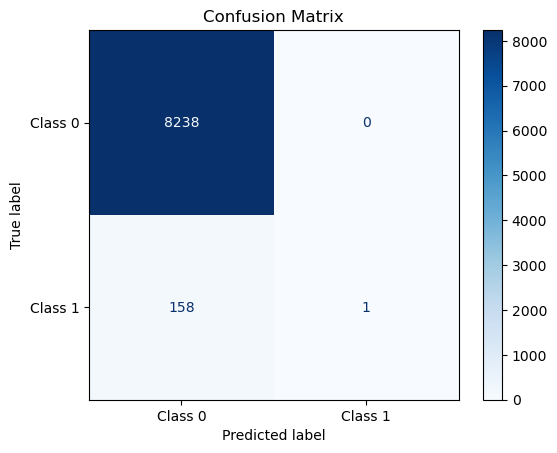

In [165]:
y_pred = randomized_search.best_estimator_.predict(X_test)

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Настройка RandomizedSearchCV (Recall)

In [167]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    cv=5, 
    scoring='recall',
    random_state=RANDOM_STATE, 
    n_jobs=-1
)

In [168]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['customer_type',
                                                                                'event',
                                                                                'Most_Frequent_Category']),
                                                                              ('num',
                                                                               Pi...
                                                                  random_state=42,
                                                                  subsample=0.7)],
                                         'model__colsample_bytree': [0.7, 0.8,
                                                                     1.0],
                                         'model__learning_rate': [0.01, 0.1,
                                                                  0.2],
                                         'model__max_depth': [3, 5, 7, -1],
                                         'model__n_estimators': [50, 100, 200,
                                                                 300],
                                         'model__num_leaves': [15, 31, 63],
                                         'model__subsample': [0.7, 0.8, 1.0],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42, scoring='recall')

In [169]:
best_params_recall = randomized_search.best_params_
best_score_recall = randomized_search.best_score_
best_model_recall = randomized_search.best_estimator_

In [170]:
best_params_recall

{'preprocessor__num__scaler': 'passthrough',
 'model__kernel': 'poly',
 'model__gamma': 'scale',
 'model__C': 10,
 'model': SVC(C=10, class_weight='balanced', kernel='poly', random_state=42)}

In [171]:
best_score_recall

0.8951443986036178

C:\Users\levle\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


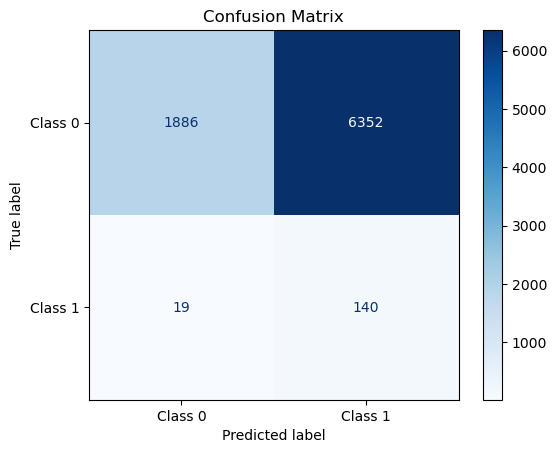

In [172]:
y_pred = best_model_recall.predict(X_test)

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [173]:
target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

In [320]:
961/(48888+961)

0.01927822022507974

## Вывод 

- Лучшая модель для roc_auc (0,712) была найдена и имеет такие параметры: 'model': LGBMClassifier(colsample_bytree=0.8, max_depth=3, random_state=42, subsample=0.7)}
- Альтернативная модель нацеленная на Рекол (0,895) имеет такие параметры: 'model': SVC(C=10, class_weight='balanced', kernel='poly', random_state=42)}
- Если компании главное не упустить ни одного потенциального клиента тогда следует фокусироваться на модели Рекол, если же нам важнее не беспокоить лишний раз мало вероятных клиентов то можно использовать roc_auc но тогда мы пропускаем почти всех потенциальных клиентов
- Но учитывая то что заказчик просит использовать roc_auc, то далее будем смотреть только на модель roc_auc
- в дате есть сильный дисбаланс классов. всего лишь 2% конверсий

# Значимость признаков

In [176]:
feature_importance = best_model.named_steps['model'].feature_importances_

In [177]:
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

In [178]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

In [179]:
top_20_features = importance_df.head(20)

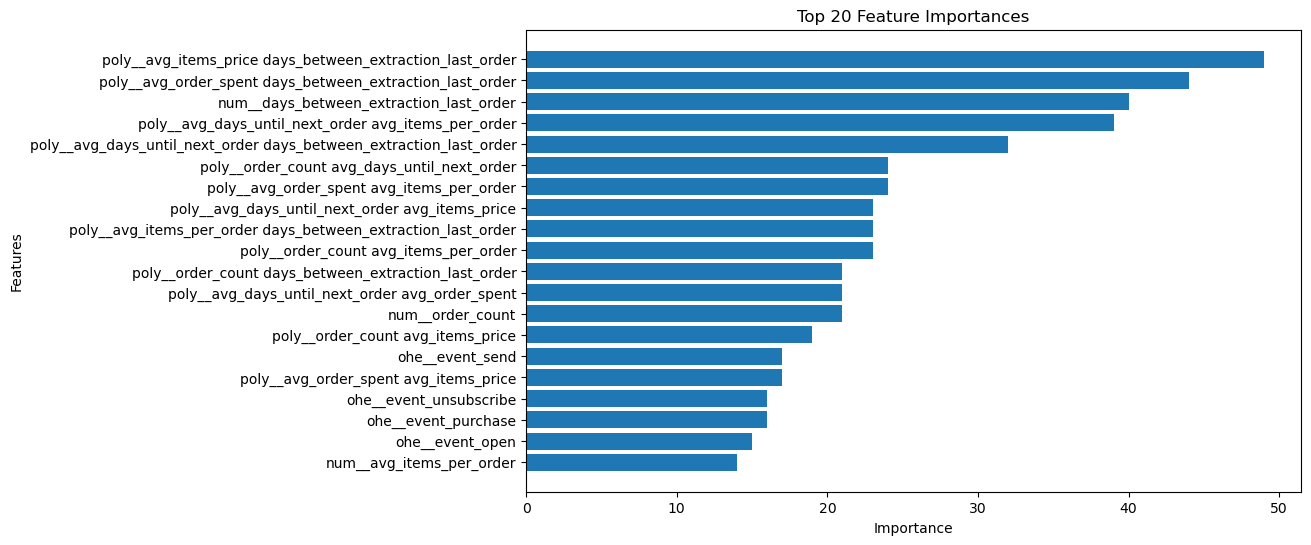

In [180]:
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Вывод

Что было сделанно?

- проведена загрузка данных
- сделан анализ датасетов
- соединение датасетов
- создание профиля клиента с метриками
- проверка на мульткоррелиальность
- создание пайплайна
- обучение 2 моделей
- график топ 20 признаков

Какой вывод?

Главный вывод в том что бизнессу возможно стоит пересмотреть целевую метрику и сделать её реколом. К сожадению фокусируясь на roc_auc метрике мы слишком стремимся к тому чтобу не было ошибок из-за чего мы не можем предсказать потенциального покупателя (стоит учесть что только 2% клиентов будут конвертированны, что создаёт огромный дисбаланс классов и возможно не большую выборку TP. 

Рекомендации:

- Добавить признаков. Например можно добавить продукт айди и с помощью него стандартизировать категории.Возможно смотреть на то из-за чего клиенты изначально совершили покупку, некоторые клиенты возвращаются на скидочные  предложения (у нас этой информации здесь нет), способ оплаты и тд
- Возможно стоит поговорить с маркетологами и узнать какие еще факторы они считают полезными для предсказаний
- зачем нам предоставленна информация по клиентам которые отписались?
- Больше примеров конвертации
- Поменять метрику измирения модели на рекол
- нужно больше положительных признаков
